# Stable Diffusion Icons: Fine-Tune Training of Stable Diffusion

Based on: [Pokemon FineTuning from Lambda Labs ML](https://github.com/LambdaLabsML/examples/blob/main/stable-diffusion-finetuning/pokemon_finetune.ipynb)



In [1]:
# Note: Run this cell, then you'll need to click the "Restart" button that pops up
# this is a result of the installation, and I don't think there's any way around this.

#!git clone https://github.com/devonbrackbill/stable-diffusion.git
#%cd stable-diffusion
#!pip install --upgrade pip
!pip install -r requirements.txt

!pip install --upgrade keras # on lambda stack we need to upgrade keras
!pip uninstall -y torchtext # on colab we need to remove torchtext

!pip install huggingface_hub

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113
Obtaining taming-transformers from git+https://github.com/CompVis/taming-transformers.git@master#egg=taming-transformers (from -r requirements.txt (line 24))
  Cloning https://github.com/CompVis/taming-transformers.git (to revision master) to ./src/taming-transformers
  Running command git clone --filter=blob:none --quiet https://github.com/CompVis/taming-transformers.git /home/ubuntu/stable-diffusion/src/taming-transformers
  Resolved https://github.com/CompVis/taming-transformers.git to commit 24268930bf1dce879235a7fddd0b2355b84d7ea6
  Preparing metadata (setup.py) ... done
Obtaining clip from git+https://github.com/openai/CLIP.git@main#egg=clip (from -r requirements.txt (line 25))
  Cloning https://github.com/openai/CLIP.git (to revision main) to ./src/clip
  Running command git clone --filter=blob:none --quiet https://gith

# 1. Download Image Icons from FontAwesome

In [2]:
!pip install cairosvg pandas

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.9/69.9 kB 21.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for cairocffi: filename=cairocffi-1.4.0-py3-none-any.whl size=88776 sha256=64a811cb69ea0e42c36cae12657950203e47d8c95726a5af0b56b32f9515febf
  Stored in directory: /home/ubuntu/.cache/pip/wheels/01/a9/c0/5c05f9dd73c21f9a7716690642823cdba55594d17a9bd69daf
Successfully built cairocffi
--- Logging error ---
Traceback (most recent call last):
  File "/home/ubuntu/.local/lib/python3.8/site-packages/pip/_internal/utils/logging.py", line 177, in emit
    self.console.print(renderable, overflow="ignore", crop=False, style=style)
  File "/home/ubuntu/.local/lib/python3.8/site-packages/pip/_vendor/rich/console.py", line 1673, in print
    extend(render(renderable, render_options))
  File "/home/ubuntu/.loc

In [5]:
import os
import subprocess
import zipfile
import cairosvg
import pandas as pd
import json
import cv2
from PIL import Image

In [19]:
try:
    os.mkdir('res')
    print('created /res directory')
except OSError:
    print("res/ already exists")

created /res directory


In [20]:
# fetch Fontawesome
if len([file for file in os.listdir('res/') if 'fontawesome' in file]) == 0:
    subprocess.call(
        ["wget", 
        "https://use.fontawesome.com/releases/v6.2.0/fontawesome-free-6.2.0-web.zip", 
        "--directory-prefix=res"])
else:
    print("fontawesome is already downloaded: {}".format([file for file in os.listdir('res/') if 'fontawesome' in file]))

--2022-10-25 20:49:08--  https://use.fontawesome.com/releases/v6.2.0/fontawesome-free-6.2.0-web.zip
Resolving use.fontawesome.com (use.fontawesome.com)... 2606:4700:e2::ac40:850f, 2606:4700:e2::ac40:840f, 172.64.133.15, ...
Connecting to use.fontawesome.com (use.fontawesome.com)|2606:4700:e2::ac40:850f|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6370953 (6.1M) [application/zip]
Saving to: ‘res/fontawesome-free-6.2.0-web.zip’

     0K .......... .......... .......... .......... ..........  0% 1.46M 4s
    50K .......... .......... .......... .......... ..........  1% 2.67M 3s
   100K .......... .......... .......... .......... ..........  2% 2.09M 3s
   150K .......... .......... .......... .......... ..........  3% 6.56M 2s
   200K .......... .......... .......... .......... ..........  4% 5.81M 2s
   250K .......... .......... .......... .......... ..........  4% 3.23M 2s
   300K .......... .......... .......... .......... ..........  5% 6.41M 2s
   350K 

In [21]:
# unzip
fontawesome_dir = ['res/' + file for file in os.listdir('res/') if 'fontawesome' in file and '.zip' in file][0]

with zipfile.ZipFile(fontawesome_dir,"r") as zip_ref:
    zip_ref.extractall("res")

fontawesome_dir = ['res/' + file for file in os.listdir('res/') if 'fontawesome' in file and 'zip' not in file][0]

print('FontAwesome files saved in: {}'.format(fontawesome_dir))


FontAwesome files saved in: res/fontawesome-free-6.2.0-web


In [22]:
# read svg file -> png data
WIDTH = 512
HEIGHT = 512
png_dir = 'res/fontawesome-png'

try:
    os.mkdir(png_dir)
except OSError:
    print("{} already exists".format(png_dir))

files = sorted(os.listdir(os.path.join(fontawesome_dir, 'svgs', 'solid')))

filenames = [file.split('.svg')[0] for file in files]
textdescrip = [file.replace('-', ' ') for file in filenames]
filenames_png = [file + '.png' for file in filenames]

for file, filename in zip(files, filenames):
    cairosvg.svg2png(url=os.path.join(fontawesome_dir, 'svgs', 'solid', file), 
                     output_width=WIDTH, 
                     output_height=HEIGHT,
                     write_to=os.path.join(png_dir, filename + '.png'))
    # read in the image
    img = cv2.imread(os.path.join(png_dir, filename + '.png'), cv2.IMREAD_UNCHANGED)

    if len(img.shape) and img.shape[2] == 4:

        # change black -> white and white -> black
        img[:,:,0] = 255-img[:,:,3]
        img[:,:,1] = 255-img[:,:,3]
        img[:,:,2] = 255-img[:,:,3]
        # remove 4th color channel (4th is alpha channel)
        img = img[:, :, :3]

        cv2.imwrite(os.path.join(png_dir, filename + '.png'), img)
    else:
        print("Image does not have 4 channels; deleting it: {}".format(os.path.join(png_dir, filename + '.png')))
        os.unlink(os.path.join(png_dir, filename + '.png'))

Image does not have 4 channels; deleting it: res/fontawesome-png/square-full.png


In [14]:
filenames_df = pd.DataFrame({#'file_name' : files,
                             'file_name': filenames_png,
                             'text': textdescrip})
filenames_df.tail()

,file_name,text
1383,xmarks-lines.png,xmarks lines
1384,y.png,y
1385,yen-sign.png,yen sign
1386,yin-yang.png,yin yang
1387,z.png,z


In [9]:
metadata = []
for idx, row in filenames_df.iterrows():
    metadata.append({'file_name': row['file_name'],
                   'text': row['text']})

In [10]:
metadata_list_of_strs = []
for item in metadata:
    metadata_list_of_strs.append(json.dumps(item))

In [11]:
# metadata_string = '\n'.join(metadata_list_of_strs)

In [11]:
with open(os.path.join(png_dir, 'metadata.txt'), 'w') as f:
  # f.writelines(metadata_list_of_strs)
  for line in metadata_list_of_strs:
      f.write(line + '\n')

# convert to .jsonl file
os.rename(os.path.join(png_dir, 'metadata.txt'), os.path.join(png_dir, 'metadata.jsonl'))

In [12]:
filenames_df[filenames_df['file_name'].str.contains('train')]

,file_name,text
1246,train-subway.png,train subway
1247,train-tram.png,train tram
1248,train.png,train


In [13]:
[file for file in os.listdir(png_dir) if 'json' in file]

['metadata.jsonl']

# 2. Convert to Right format for Stable Diffusion Pytorch (HuggingFace DataSet object)

In [14]:
# Check the dataset
from datasets import load_dataset
# ds = load_dataset("lambdalabs/pokemon-blip-captions", split="train")
# sample = ds[0]
# display(sample["image"].resize((256, 256)))
# print(sample["text"])

In [15]:
# ds = load_dataset("imagefolder", 
#                   data_files={"train": "res/fontawesome-png/**", 
#                               #"test": "path/to/test/**", 
#                               #"valid": "path/to/valid/**"
#                               })
ds = load_dataset("imagefolder", 
                  data_dir="res/fontawesome-png/", split="train")

Using custom data configuration default-e9acb79c66f0c46a


Extracting data files: 0it [00:00, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset imagefolder downloaded and prepared to /home/ubuntu/.cache/huggingface/datasets/imagefolder/default-e9acb79c66f0c46a/0.0.0/0fc50c79b681877cc46b23245a6ef5333d036f48db40d53765a68034bc48faff. Subsequent calls will reuse this data.


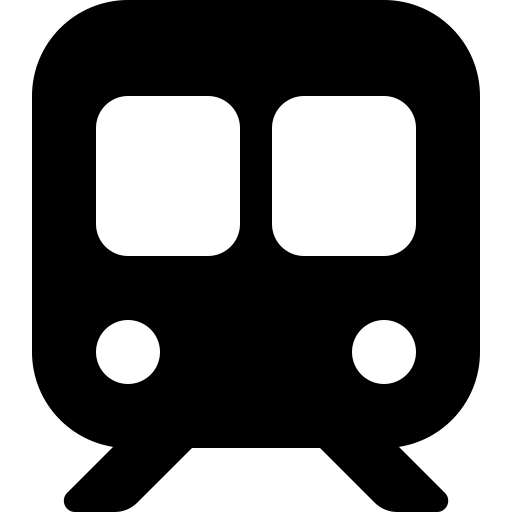

train subway


In [16]:
sample = ds[0]
display(sample["image"])
print(sample["text"])

In [17]:
sample

{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=512x512 at 0x7F0249E3E130>,
 'text': 'train subway'}

# 3. Fine Tune Stable Diffusion

copied from: https://github.com/LambdaLabsML/examples/blob/main/stable-diffusion-finetuning/pokemon_finetune.ipynb

In [18]:
!nvidia-smi

Tue Oct 25 11:30:31 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  On   | 00000000:06:00.0 Off |                    0 |
| N/A   29C    P0    42W / 400W |      2MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [20]:
# from google.colab import output
# output.enable_custom_widget_manager()

In [19]:
#!pip install huggingface_hub
from huggingface_hub import notebook_login
notebook_login()

In [20]:
from huggingface_hub import hf_hub_download
ckpt_path = hf_hub_download(repo_id="CompVis/stable-diffusion-v-1-4-original", 
                            filename="sd-v1-4-full-ema.ckpt", 
                            use_auth_token=True)

Downloading:   0%|          | 0.00/7.70G [00:00<?, ?B/s]

In [21]:
# 2xA6000:

# BATCH_SIZE = 4
BATCH_SIZE = 1
N_GPUS = 1
ACCUMULATE_BATCHES = 1

if N_GPUS > 1:
  gpu_list = ",".join((str(x) for x in range(N_GPUS))) + ","
else:
  gpu_list = "0"
print(f"Using GPUs: {gpu_list}")

Using GPUs: 0


In [22]:
!pwd

/home/ubuntu/stable-diffusion


In [23]:
ckpt_path

'/home/ubuntu/.cache/huggingface/hub/models--CompVis--stable-diffusion-v-1-4-original/snapshots/0834a76f88354683d3f7ef271cadd28f4757a8cc/sd-v1-4-full-ema.ckpt'

In [24]:
! ls /root/.cache/huggingface/hub/models--CompVis--stable-diffusion-v-1-4-original/snapshots/0834a76f88354683d3f7ef271cadd28f4757a8cc/sd-v1-4-full-ema.ckpt

ls: cannot access '/root/.cache/huggingface/hub/models--CompVis--stable-diffusion-v-1-4-original/snapshots/0834a76f88354683d3f7ef271cadd28f4757a8cc/sd-v1-4-full-ema.ckpt': Permission denied


Note:

Here, I needed to add a new helper function in `stable-diffusion/ldm/data/simple` called `hf_dataset_from_local()` with the following code:

```
def hf_dataset_from_local(
    name,
    data_dir,
    image_transforms=[],
    image_column="image",
    text_column="text",
    split='train',
    image_key='image',
    caption_key='txt',
    ):
    """Make huggingface dataset with appropriate list of transforms applied
    """
    ds = load_dataset(name, data_dir=data_dir, split=split)
    image_transforms = [instantiate_from_config(tt) for tt in image_transforms]
    image_transforms.extend([transforms.ToTensor(),
                                transforms.Lambda(lambda x: rearrange(x * 2. - 1., 'c h w -> h w c'))])
    tform = transforms.Compose(image_transforms)

    assert image_column in ds.column_names, f"Didn't find column {image_column} in {ds.column_names}"
    assert text_column in ds.column_names, f"Didn't find column {text_column} in {ds.column_names}"

    def pre_process(examples):
        processed = {}
        processed[image_key] = [tform(im) for im in examples[image_column]]
        processed[caption_key] = examples[text_column]
        return processed

    ds.set_transform(pre_process)
    return ds
```

In [25]:
yaml = \
"""model:
  base_learning_rate: 1.0e-04
  target: ldm.models.diffusion.ddpm.LatentDiffusion
  params:
    linear_start: 0.00085
    linear_end: 0.0120
    num_timesteps_cond: 1
    log_every_t: 200
    timesteps: 1000
    first_stage_key: "image"
    cond_stage_key: "txt"
    image_size: 64
    channels: 4
    cond_stage_trainable: false   # Note: different from the one we trained before
    conditioning_key: crossattn
    scale_factor: 0.18215

    scheduler_config: # 10000 warmup steps
      target: ldm.lr_scheduler.LambdaLinearScheduler
      params:
        warm_up_steps: [ 1 ] # NOTE for resuming. use 10000 if starting from scratch
        cycle_lengths: [ 10000000000000 ] # incredibly large number to prevent corner cases
        f_start: [ 1.e-6 ]
        f_max: [ 1. ]
        f_min: [ 1. ]

    unet_config:
      target: ldm.modules.diffusionmodules.openaimodel.UNetModel
      params:
        image_size: 32 # unused
        in_channels: 4
        out_channels: 4
        model_channels: 320
        attention_resolutions: [ 4, 2, 1 ]
        num_res_blocks: 2
        channel_mult: [ 1, 2, 4, 4 ]
        num_heads: 8
        use_spatial_transformer: True
        transformer_depth: 1
        context_dim: 768
        use_checkpoint: True
        legacy: False

    first_stage_config:
      target: ldm.models.autoencoder.AutoencoderKL
      ckpt_path: "models/first_stage_models/kl-f8/model.ckpt"
      params:
        embed_dim: 4
        monitor: val/rec_loss
        ddconfig:
          double_z: true
          z_channels: 4
          resolution: 256
          in_channels: 3
          out_ch: 3
          ch: 128
          ch_mult:
          - 1
          - 2
          - 4
          - 4
          num_res_blocks: 2
          attn_resolutions: []
          dropout: 0.0
        lossconfig:
          target: torch.nn.Identity

    cond_stage_config:
      target: ldm.modules.encoders.modules.FrozenCLIPEmbedder


data:
  target: main.DataModuleFromConfig
  params:
    batch_size: 4
    num_workers: 4
    num_val_workers: 0 # Avoid a weird val dataloader issue
    train:
      target: ldm.data.simple.hf_dataset_from_local
      params:
        name: imagefolder
        data_dir: res/fontawesome-png
        image_transforms:
        - target: torchvision.transforms.Resize
          params:
            size: 512
            interpolation: 3
        - target: torchvision.transforms.RandomCrop
          params:
            size: 512
        # - target: torchvision.transforms.RandomHorizontalFlip
        text_column: text
        image_column: image
        caption_key: text
    validation:
      target: ldm.data.simple.TextOnly
      params:
        captions:
        - "radar"
        - "bunny rabbit"
        - "Yoda"
        - "coffee"
        - "palm tree"
        - "evergreen tree"
        - "toucan"
        - "thumbs up"
        - "butterfly"
        output_size: 512
        n_gpus: 1 # small hack to sure we see all our samples; # I changed this to 1


lightning:
  find_unused_parameters: False

  modelcheckpoint:
    params:
      every_n_train_steps: 2000
      save_top_k: -1
      monitor: null

  callbacks:
    image_logger:
      target: main.ImageLogger
      params:
        batch_frequency: 2000
        max_images: 4
        increase_log_steps: False
        log_first_step: True
        log_all_val: True
        log_images_kwargs:
          use_ema_scope: True
          inpaint: False
          plot_progressive_rows: False
          plot_diffusion_rows: False
          N: 4
          unconditional_guidance_scale: 3.0
          unconditional_guidance_label: [""]

  trainer:
    benchmark: True
    num_sanity_val_steps: 0
    accumulate_grad_batches: 1
"""

with open('configs/stable-diffusion/retrain-icons.yaml', 'w') as f:
  f.write(yaml)

In [26]:
gpu_list

'0'

In [27]:
! ls

LICENSE			    im-examples		       requirements.txt
README.md		    latent_diffusion.egg-info  res
StableDiffusionIcons.ipynb  ldm			       scripts
assets			    main.py		       setup.py
configs			    models		       src
data			    notebook_helpers.py
examples		    notebooks


In [28]:
# # Run training (original command)
# !(python main.py \
#     -t \
#     --base configs/stable-diffusion/retrain-icons.yaml \
#     --gpus "$gpu_list" \
#     --scale_lr False \
#     --num_nodes 1 \
#     --check_val_every_n_epoch 10 \
#     --finetune_from "$ckpt_path" \
#     data.params.batch_size="$BATCH_SIZE" \
#     lightning.trainer.accumulate_grad_batches="$ACCUMULATE_BATCHES" \
#     data.params.validation.params.n_gpus="$NUM_GPUS" \
# )

In [2]:
# img_pil = Image.open('res/fontawesome-png/anchor-lock.png')
# print('Pillow: ', img_pil.mode, img_pil.size)

# img = cv2.imread('res/fontawesome-png/anchor-lock.png', cv2.IMREAD_UNCHANGED)
# print('OpenCV: ', img.shape)

# img = cv2.imread('res/fontawesome-png/anchor-lock.png', cv2.IMREAD_UNCHANGED)
# print('OpenCV: ', img.shape)

Pillow:  RGBA (512, 512)


In [29]:
# Run training
!(python main.py \
    -t \
    --base configs/stable-diffusion/retrain-icons.yaml \
    --auto_select_gpus \
    --gpus=1 \
    --scale_lr False \
    --num_nodes 1 \
    --check_val_every_n_epoch 10 \
    --finetune_from "$ckpt_path" \
    data.params.batch_size="$BATCH_SIZE" \
    lightning.trainer.accumulate_grad_batches=1 \
    data.params.validation.params.n_gpus=1 \
)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.
Moving 0 files to the new cache system
0it [00:00, ?it/s]
Global seed set to 23
Running on GPUs 1
LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 859.52 M params.
Keeping EMAs of 688.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels
Downloading: "https://github.com/DagnyT/hardnet/raw/master/pretrained/train_liberty_with_aug/checkpoint_liberty_with_aug.pth" to /home/ubuntu/.cache/torch/hub/checkpoints/checkpoint_liberty_with_aug.pth
100%|███████████████████████████████████████| 5.10M/5.10M [00:00<00:00, 289MB/s]
Downloading: 100%|███████████████████████████| 961k/961k [00:00<00:00, 23.7MB/s]
Downloading: 100%|██████████

In [51]:
# # Run training
# !(python main.py \
#     -t \
#     --base configs/stable-diffusion/retrain-icons.yaml \
#     --gpus=1 \
#     --scale_lr False \
#     --num_nodes 1 \
#     --check_val_every_n_epoch 10 \
#     --finetune_from "$ckpt_path" \
#     data.params.batch_size="$BATCH_SIZE" \
#     lightning.trainer.accumulate_grad_batches=1 \
#     data.params.validation.params.n_gpus=1 \
# )

Global seed set to 23
Running on GPUs 1
LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 859.52 M params.
Keeping EMAs of 688.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels
Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPTextModel: ['vision_model.encoder.layers.3.mlp.fc1.weight', 'vision_model.encoder.layers.7.self_attn.v_proj.bias', 'vision_model.encoder.layers.23.layer_norm1.weight', 'vision_model.encoder.layers.10.self_attn.out_proj.bias', 'vision_model.encoder.layers.1.layer_norm2.bias', 'vision_model.pre_layrnorm.bias', 'vision_model.encoder.layers.22.layer_norm1.weight', 'vision_model.encoder.layers.16.mlp.fc2.bias', 'vision_model.encoder.layers.11.mlp.fc1.bias', 'vision_model.encoder.layers.18.mlp.fc1.bias', 'vision_model.encoder.layers.23.self_attn.k_proj.weight', 'vision_model.p

In [45]:
# # Run training
# !(python main.py \
#     -t \
#     --base configs/stable-diffusion/retrain-icons.yaml \
#     --auto_select_gpus \
#     --scale_lr False \
#     --num_nodes 1 \
#     --check_val_every_n_epoch 10 \
#     --finetune_from "$ckpt_path" \
#     data.params.batch_size="$BATCH_SIZE" \
#     lightning.trainer.accumulate_grad_batches="$ACCUMULATE_BATCHES" \
#     data.params.validation.params.n_gpus="$NUM_GPUS" \
# )

Global seed set to 23
LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 859.52 M params.
Keeping EMAs of 688.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels
Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPTextModel: ['vision_model.encoder.layers.17.layer_norm1.bias', 'vision_model.encoder.layers.1.layer_norm1.weight', 'vision_model.encoder.layers.18.self_attn.k_proj.bias', 'vision_model.encoder.layers.7.mlp.fc2.bias', 'vision_model.encoder.layers.6.layer_norm1.weight', 'vision_model.encoder.layers.6.self_attn.k_proj.bias', 'vision_model.encoder.layers.20.mlp.fc2.weight', 'vision_model.encoder.layers.23.self_attn.v_proj.weight', 'vision_model.encoder.layers.1.self_attn.out_proj.bias', 'vision_model.encoder.layers.14.mlp.fc1.bias', 'vision_model.encoder.layers.4.mlp.fc1.weight', 'vision_mode